In [1]:
import numpy as np
import pandas as pd
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import FunctionTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from pykalman import KalmanFilter
from scipy.fft import fft, ifft

#import revelant files
from data_smoothing import output_kalman, kalmanSmooth, lowess_smooth, fft_denoise, apply_fft_denoise

# Load data

In [2]:
folder_path = 'original_data'
#folder_path = 'fft_denoised'
#folder_path = 'kalman_smoothed'
#folder_path = 'lowess_smoothed'

csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

run_df = pd.DataFrame()
walk_df = pd.DataFrame()
jump_df = pd.DataFrame()
still_df = pd.DataFrame()
multi_df = pd.DataFrame()

run_files = list()
walk_files = list()
jump_files = list()
still_files = list()
multi_files = list()


# We have at least 5 motion labels
for file in csv_files:
    file_path = os.path.join(folder_path, file)
    if 'Run' in file:
        temp_df = pd.read_csv(file_path)
        run_df = pd.concat([run_df, temp_df], ignore_index=True)
        run_files.append(temp_df)
    elif 'Walk' in file:
        temp_df = pd.read_csv(file_path)
        walk_df = pd.concat([walk_df, temp_df], ignore_index=True)
        walk_files.append(temp_df)
    elif 'Jump' in file:
        temp_df = pd.read_csv(file_path)
        jump_df = pd.concat([jump_df, temp_df], ignore_index=True)
        jump_files.append(temp_df)
    elif 'Still' in file:
        temp_df = pd.read_csv(file_path)
        still_df = pd.concat([still_df, temp_df], ignore_index=True)
        still_files.append(temp_df)
    elif 'Multi' in file:
        temp_df = pd.read_csv(file_path)
        multi_df = pd.concat([multi_df, temp_df], ignore_index=True)
        multi_files.append(temp_df)

## Data Smoothing

In [3]:
#We have process the data into dedicated folder, no need do it again
#After we smoothed the data, we need to load new data again
'''
# Function to process each file group
def process_file_group(file_group, label):
    for i, df in enumerate(file_group, start=1):
        file_name = f'{label}{i}'
        lowess_smooth(df, file_name)
        output_kalman(df, file_name)
        apply_fft_denoise(df, file_name)
        
# Dictionary mapping labels to file lists
file_groups = {
    'run': run_files,
    'walk': walk_files,
    'still': still_files,
    'jump': jump_files,
    'multi': multi_files
}


# Process each file group
for label, files in file_groups.items():
    process_file_group(files, label)
'''

"\n# Function to process each file group\ndef process_file_group(file_group, label):\n    for i, df in enumerate(file_group, start=1):\n        file_name = f'{label}{i}'\n        lowess_smooth(df, file_name)\n        output_kalman(df, file_name)\n        apply_fft_denoise(df, file_name)\n        \n# Dictionary mapping labels to file lists\nfile_groups = {\n    'run': run_files,\n    'walk': walk_files,\n    'still': still_files,\n    'jump': jump_files,\n    'multi': multi_files\n}\n\n\n# Process each file group\nfor label, files in file_groups.items():\n    process_file_group(files, label)\n"

## Plotting

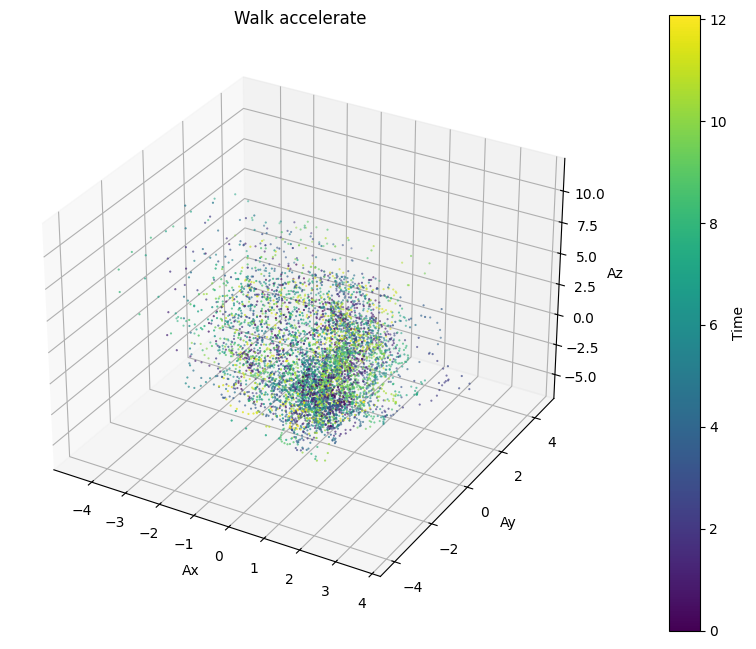

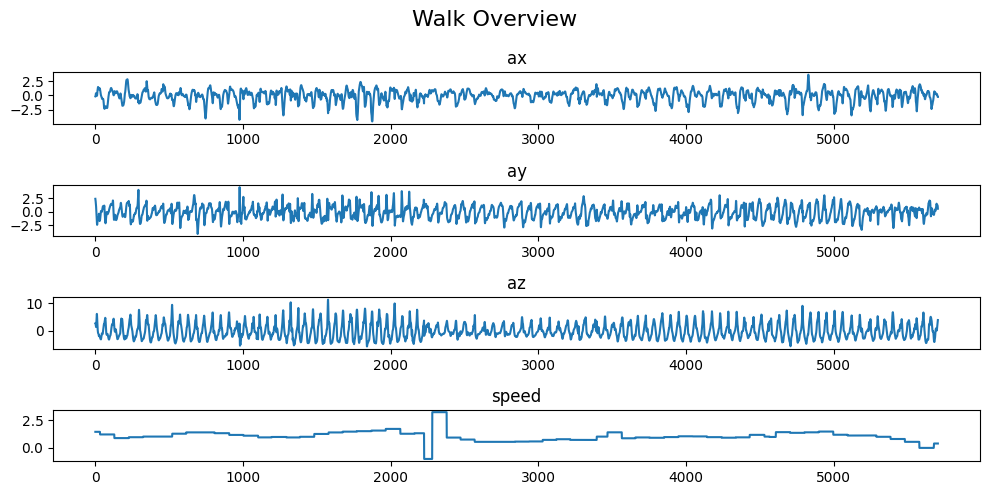

In [4]:

fig1 = plt.figure(figsize=(10, 8))
ax = fig1.add_subplot(111, projection='3d')

sc1 = ax.scatter(walk_df['ax'], walk_df['ay'], walk_df['az'], c=walk_df['time'], cmap='viridis',marker='o', s=0.3)

cbar = plt.colorbar(sc1, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_title('Walk accelerate')
ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig1)


plt.figure(figsize=(10, 5))
x = np.arange(0, len(walk_df['time']))

for i, col in enumerate(walk_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, walk_df[col],marker='', linestyle='-')
    plt.title(f'{col}')
    
plt.suptitle('Walk Overview', fontsize=16)
plt.tight_layout()
plt.show()

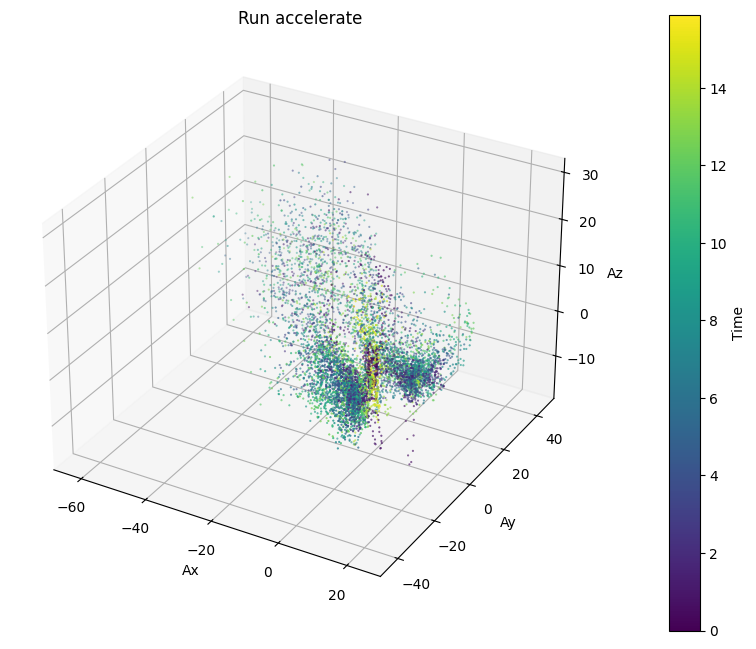

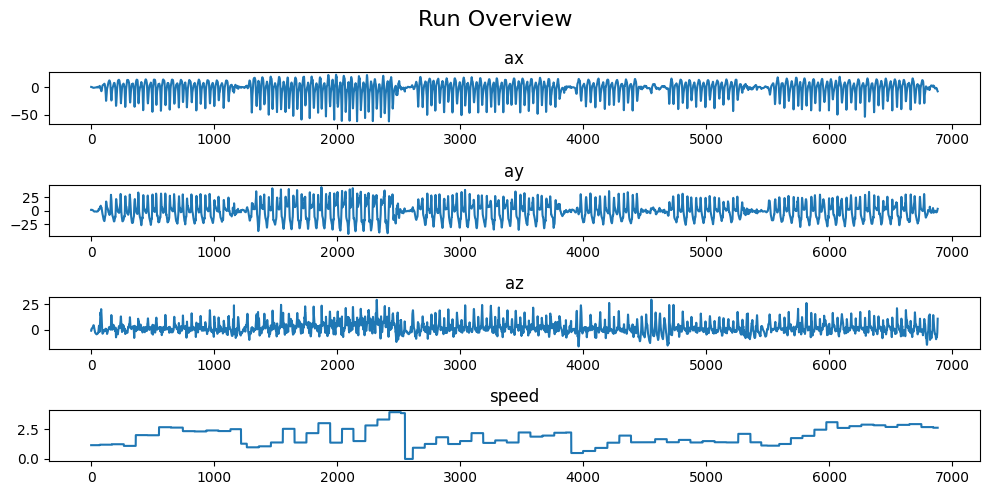

In [5]:
fig2 = plt.figure(figsize=(10, 8))
ax = fig2.add_subplot(111, projection='3d')

sc2 = ax.scatter(run_df['ax'], run_df['ay'], run_df['az'], c=run_df['time'], cmap='viridis',marker='o', s = 0.3)

cbar = plt.colorbar(sc2, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_title('Run accelerate')
ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig2)

plt.figure(figsize=(10, 5))
x = np.arange(0, len(run_df['time']))

for i, col in enumerate(run_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, run_df[col],marker='', linestyle='-')
    plt.title(f'{col}')

plt.suptitle('Run Overview', fontsize=16)
plt.tight_layout()
plt.show()

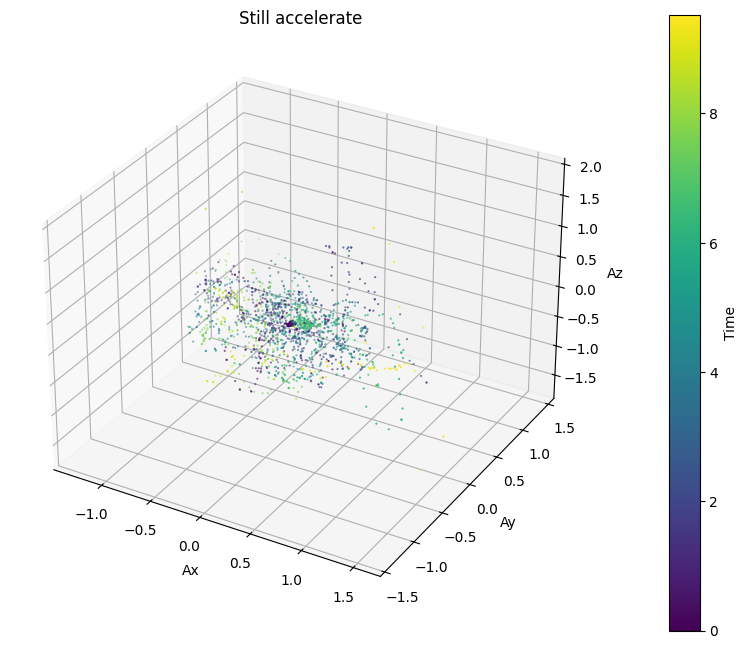

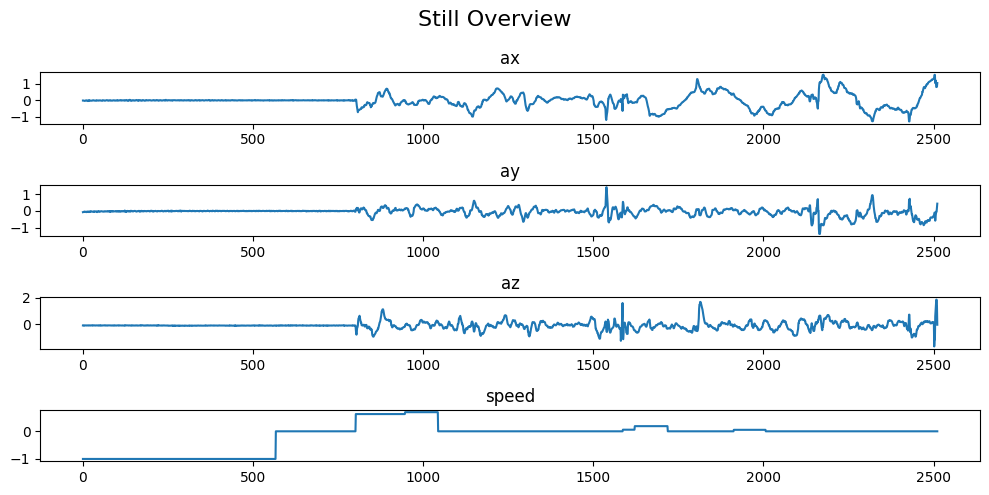

In [6]:
fig3 = plt.figure(figsize=(10, 8))
ax = fig3.add_subplot(111, projection='3d')

sc3 = ax.scatter(still_df['ax'], still_df['ay'], still_df['az'], c=still_df['time'], cmap='viridis',marker='o', s = 0.3)

cbar = plt.colorbar(sc3, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_title('Still accelerate')
ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig3)


plt.figure(figsize=(10, 5))
x = np.arange(0, len(still_df['time']))

for i, col in enumerate(still_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, still_df[col],marker='', linestyle='-')
    plt.title(f'{col}')
    
plt.suptitle('Still Overview', fontsize=16)
plt.tight_layout()
plt.show()

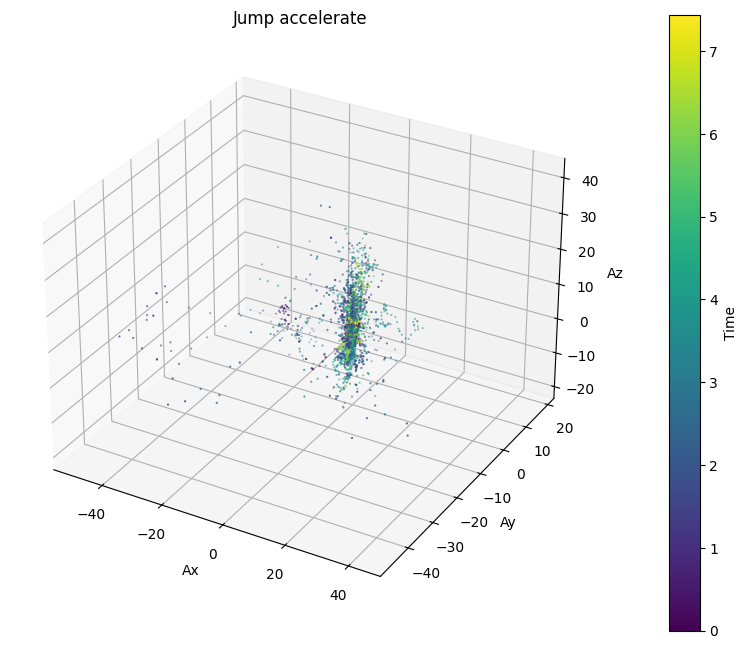

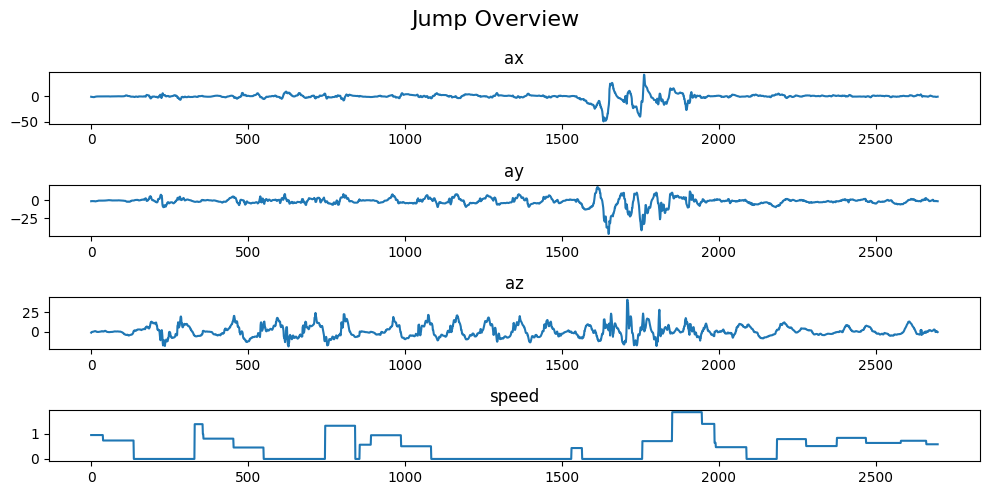

In [7]:
fig4 = plt.figure(figsize=(10, 8))
ax = fig4.add_subplot(111, projection='3d')

sc4 = ax.scatter(jump_df['ax'], jump_df['ay'], jump_df['az'], c=jump_df['time'], cmap='viridis',marker='o', s = 0.3)

cbar = plt.colorbar(sc4, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_title('Jump accelerate')
ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig4)

plt.figure(figsize=(10, 5))
x = np.arange(0, len(jump_df['time']))

for i, col in enumerate(jump_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, jump_df[col],marker='', linestyle='-')
    plt.title(f'{col}')
    
plt.suptitle('Jump Overview', fontsize=16)
plt.tight_layout()
plt.show()

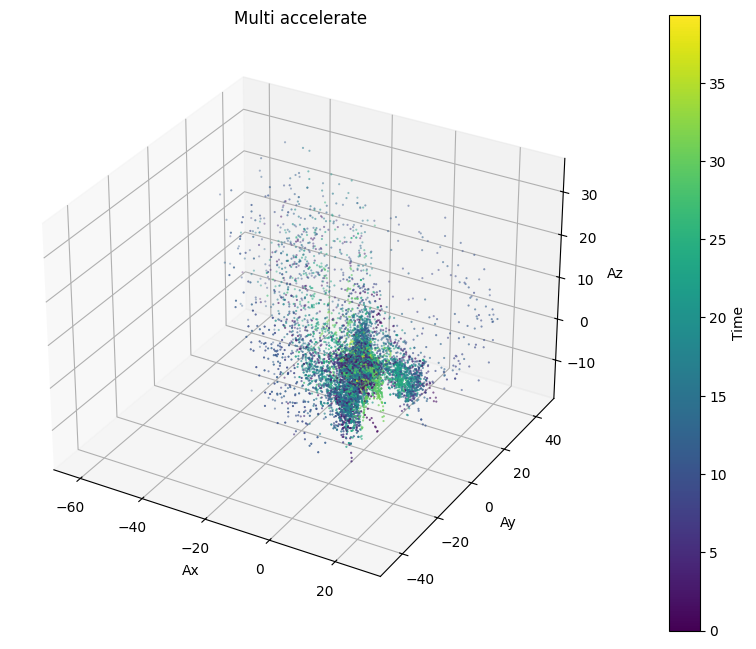

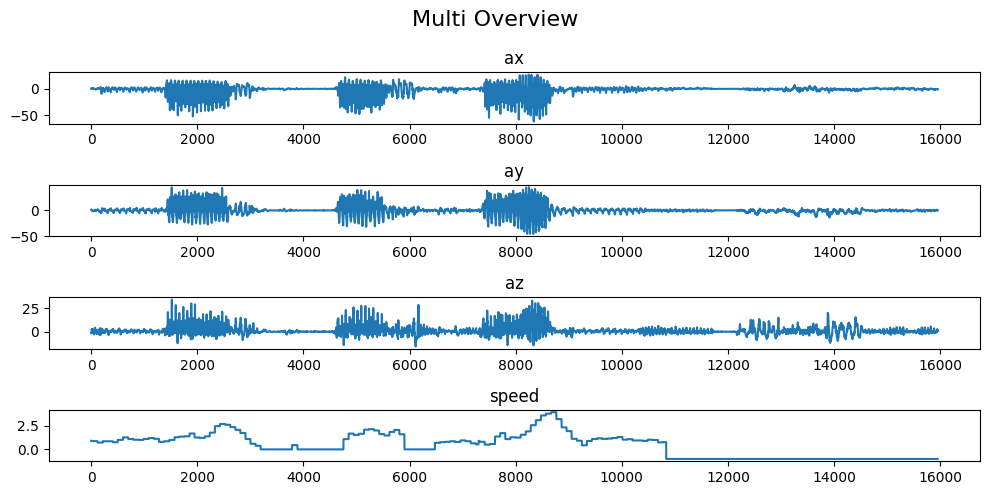

In [8]:
fig5 = plt.figure(figsize=(10, 8))
ax = fig5.add_subplot(111, projection='3d')

sc5 = ax.scatter(multi_df['ax'], multi_df['ay'], multi_df['az'], c=multi_df['time'], cmap='viridis',marker='o', s = 0.3)

cbar = plt.colorbar(sc5, ax=ax, pad=0.1)
cbar.set_label('Time')

ax.set_title('Multi accelerate')
ax.set_xlabel('Ax')
ax.set_ylabel('Ay')
ax.set_zlabel('Az')

plt.show(fig5)

plt.figure(figsize=(10, 5))
x = np.arange(0, len(multi_df['time']))

for i, col in enumerate(multi_df.columns[1:5]):
    plt.subplot(4, 1, i+1)
    plt.plot(x, multi_df[col],marker='', linestyle='-')
    plt.title(f'{col}')
    
plt.suptitle('Multi Overview', fontsize=16)
plt.tight_layout()
plt.show()

In [9]:
dfs_combined = pd.concat([run_df, walk_df, jump_df, still_df, multi_df], ignore_index=True)
X = dfs_combined[['time','ax','ay','az','speed']]

le = LabelEncoder()
y = le.fit_transform(dfs_combined['label'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Training + Scaler

In [32]:
#scaler = StandardScaler()
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train
X_test_scaled = X_test

## MLP

Accuracy: 0.9031

Confusion Matrix:


C:\Users\lhg45\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


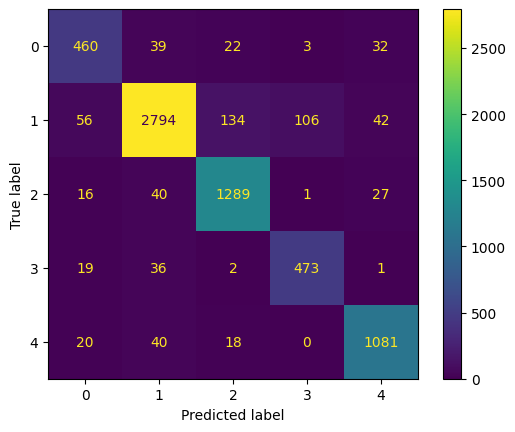

In [24]:
model_nn = MLPClassifier(
        solver = 'adam', hidden_layer_sizes=(16,32,64,128), activation='relu'
    )

model_nn.fit(X_train_scaled, y_train)
y_pred_nn = model_nn.predict(X_test_scaled)

# Evaluate the model
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Accuracy: {accuracy_nn:.4f}")

# Print confusion matrix

print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_nn))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## Gaussian Naive Bayes

Accuracy: 0.7677

Confusion Matrix:


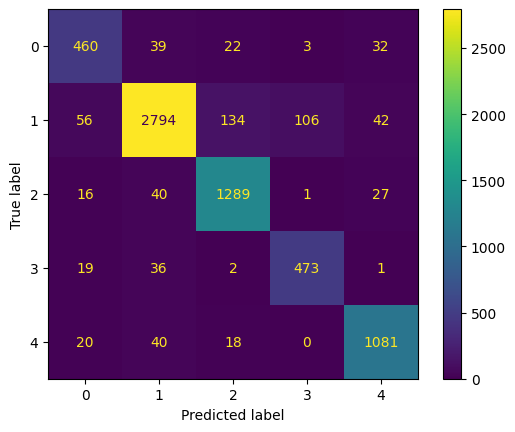

In [33]:
model_NB =  GaussianNB()
model_NB.fit(X_train_scaled, y_train)
y_pred_NB = model_NB.predict(X_test_scaled)

# Evaluate the model
accuracy_NB = accuracy_score(y_test, y_pred_NB)
print(f"Accuracy: {accuracy_NB:.4f}")

print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_NB))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## K-Nearest Neighbors Classifier

Accuracy: 0.9447

Confusion Matrix:


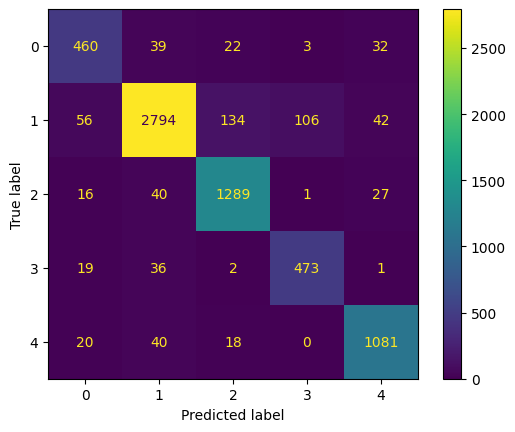

In [30]:
model_knn = KNeighborsClassifier(n_neighbors=10)
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)

# Evaluate the model
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"Accuracy: {accuracy_knn:.4f}")

# Confusion matrix
print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_knn))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

## Random Forest Classifier

Accuracy: 0.9939

Confusion Matrix:


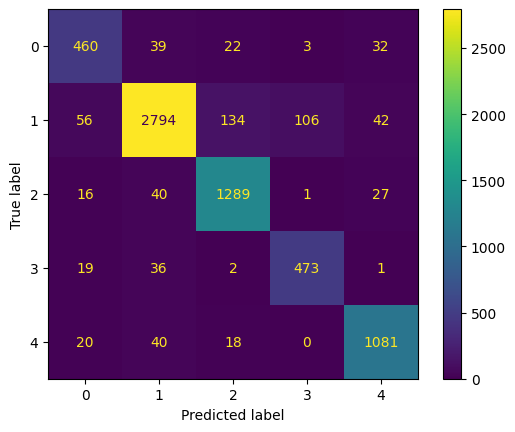

In [31]:
model_RF = RandomForestClassifier(n_estimators=150, random_state=42)

model_RF.fit(X_train_scaled, y_train)
y_pred_RF = model_RF.predict(X_test_scaled)

# Evaluate the model
accuracy_RF = accuracy_score(y_test, y_pred_RF)
print(f"Accuracy: {accuracy_RF:.4f}")

# Print confusion matrix

print("\nConfusion Matrix:")
#print(confusion_matrix(y_test, y_pred_RF))
cm = confusion_matrix(y_test, y_pred_nn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()